In [1]:
from __future__ import division
import numpy as np
import scipy.signal as sig

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')

from keras.callbacks import EarlyStopping

from shootout import stride_wit, get_signals, make_NN

Using Theano backend.


In [2]:
# Data generation parameters
fs = 1
t_train = 2**20/fs  # ~1 Million samples for training
t_val = 2**15/fs    # 30k samples for validation

fpole = 2**-5  # 32 samples per cycle
q = 8
order = 4

# NN parameters
nlayer = 2
nchunk = int(2*q/fpole)  # Sweet spot from NN_window_length

# Training parameters
nb_epoch = 40
patience = 2         # If performance on val data doesn't improve for this many epochs, stop
batch_size = 64      # How many output points to use per gradient update

fit_opts = {'batch_size': batch_size,
            'nb_epoch': nb_epoch,
            'verbose': False,
            'callbacks': [EarlyStopping(patience=patience)],
            }

In [3]:
# Little extra time for windowing of chunks
wit_train, tar_train, _ = get_signals(order, sec=t_train+(nchunk-1)/fs,
                                      fs=fs, fpole=fpole, q=q)
train = stride_wit(wit_train, nchunk)
wit_train = wit_train[-train.shape[0]:]
tar_train = tar_train[-train.shape[0]:]

wit_val, tar_val, _ = get_signals(order, sec=t_val+(nchunk-1)/fs,
                                    fs=fs, fpole=fpole, q=q)
val = stride_wit(wit_val, nchunk)
wit_val = wit_val[-val.shape[0]:]
tar_val = tar_val[-val.shape[0]:]

ntrains = [train.shape[0]//(2**ii) for ii in range(6)]

fit_opts['validation_data'] = (val, tar_val)

In [4]:
models = []
losses = []

for ii, ntrain in enumerate(ntrains):
    print 'Training on {} samples...'.format(ntrain)

    model = make_NN(train.shape[-1], nlayer=nlayer, activation='relu')
    fit = model.fit(train[-ntrain:,:], tar_train[-ntrain:], **fit_opts)
    
    models.append(model)
    losses.append(fit.history['val_loss'])
        
    print 'Done!'

Training on 1048576 samples...
Done!
Training on 524288 samples...
Done!
Training on 262144 samples...
Done!
Training on 131072 samples...
Done!
Training on 65536 samples...
Done!
Training on 32768 samples...
Done!


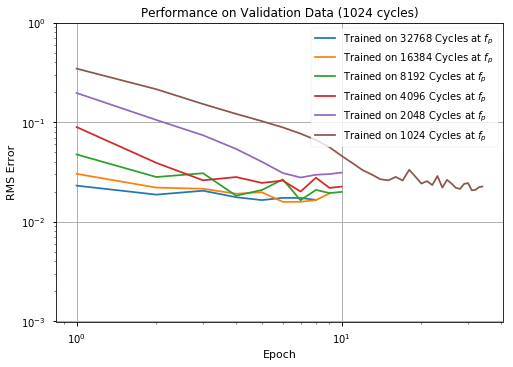

In [5]:
# Plot loss over training time
plt.figure()
for (loss, nt) in zip(losses, ntrains):
    plt.plot(np.arange(len(loss))+1, np.sqrt(loss),
             label='Trained on {} Cycles at $f_p$'.format(int(nt/fs*fpole)))

plt.title('Performance on Validation Data ({} cycles)'.format(int(tar_val.size/fs*fpole)))
plt.ylabel('RMS Error')
plt.xlabel('Epoch')
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-3, 1])
plt.legend()
plt.grid(True)

In [6]:
# Evaluate on validation data
nperseg = nchunk
psubs = []

ff, ptar = sig.welch(tar_val, fs=fs, nperseg=nperseg)
for model in models:
    pred = model.predict(val)[:,0]
    res = tar_val - pred
    _, psub = sig.welch(res, fs=fs, nperseg=nperseg)    
    psubs.append(psub)

In [7]:
# Compare with FIR Wiener filter
import noisesub as n
W = n.wiener_fir(tar_train, wit_train, nchunk)
pred = sig.lfilter(W[0], 1, wit_val)
res = tar_val - pred
_, pwf = sig.welch(res, fs=fs, nperseg=nperseg)

(0.0001, 27.269758669630395)

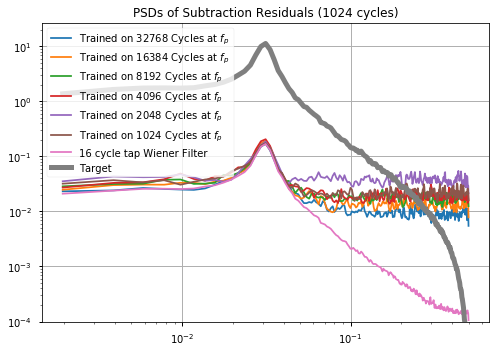

In [8]:
plt.figure()
for (nt, psub) in zip(ntrains, psubs):
    plt.loglog(ff, np.sqrt(psub),
               label='Trained on {} Cycles at $f_p$'.format(int(nt/fs*fpole)))
    
plt.loglog(ff, np.sqrt(pwf),
           label='{} cycle tap Wiener Filter'.format(int(nchunk/fs*fpole)))

plt.loglog(ff, np.sqrt(ptar), label='Target', lw=5)

plt.title('PSDs of Subtraction Residuals ({} cycles)'.format(int(tar_val.size/fs*fpole)))
plt.grid(True)
plt.legend()
plt.ylim(ymin=1e-4)